# Predicting Heart Disease

It is estimated by the World Health Organization (WHO) that 17.9 million people die from cardiovascular diseases (CVDs) every year. Unhealthy diet, lack of physical activity, or mental illness are among the multiple risk factors that could contribute to CVD in individuals. Identifying the risk factors early on could help prevent many premature deaths.

For this project, we assume the role of data scientists working for an R&D company that focuses on providing healthcare solutions. The company has already collected anonymous data from multiple hospitals on several patients. The data includes information for each patient that will be important for our work, such as personal medical data and whether or not they have had heart disease before.

Our task is to use the data to accurately predict the likelihood of a new patient having heart disease in the future.

In [1]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset Features

- Age: age of patient (years)
- Sex: sex of patient (M or F)
- ChestPainType: TA:Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic 
- RestingBP: Resting blood pressure (mm Hg)
- Cholesterol: serum cholesterol (mg/dl)
- FastingBS: fasting blood sugar (1: if fasting BS > 120mg/dl, 0: otherwise)
- RestingECG: resting electorcardiogram results (Normal:Normal, ST:Having ST-T wave abnormality(T wave inversions and/or ST elevation or depression of >0.05mV), LVH: showing probable or definite left ventricular hypertophy by Este's criteria)
- MaxHR: maximum heart-rate achieved (between 60 and 202)
- ExerciseAngina: exercise-induced angina (Y:Yes, N:No)
- Oldpeak: oldpeak = ST(numeric value measured in depression)
- ST_Slope: the slope of the peak exercise ST segment (Up:upsloping, Flat:flat, Down:downsloping)
- HeartDisease: 1:heart disease, 0:Normal  [Target Variable]

We'll first conduct exploratory data analysis on the data before we begin building a model

### Read in Data

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
len(df)

918

In this data set there are 11 features and 918 observations for these features. The target variable is the HeartDisease column.

## EDA: Descriptive Stats

Looking at the first few rows of the dataset we can see that there are both categorical and numerical features. We need to note that the FastingBS and HeartDisease columns are categorical despite being integers.

We will now begin to explore and analyze the numerical columns. We will find the average age of the patients, as well as look for any missing values or features that stand out for containing outliers. 

In [4]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No missing data in dataset

In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


- Average age of patients is 53
- Outliers present in Cholesterol column, median cholesterol is higher than the average by more than 20mm/dl.
- Minimum values for RestingBP and Cholesterol is 0 which is impossible. Some data might not be accurate.

In [6]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [7]:
len(df[df['Cholesterol']==0])

172

## EDA: Visualizations

We'll now explore the categorical features and create visualizations to help us understand better how the data is distributed.

To start, we'll look into the categorical columns for more detail as to how each category of each column is distributed.

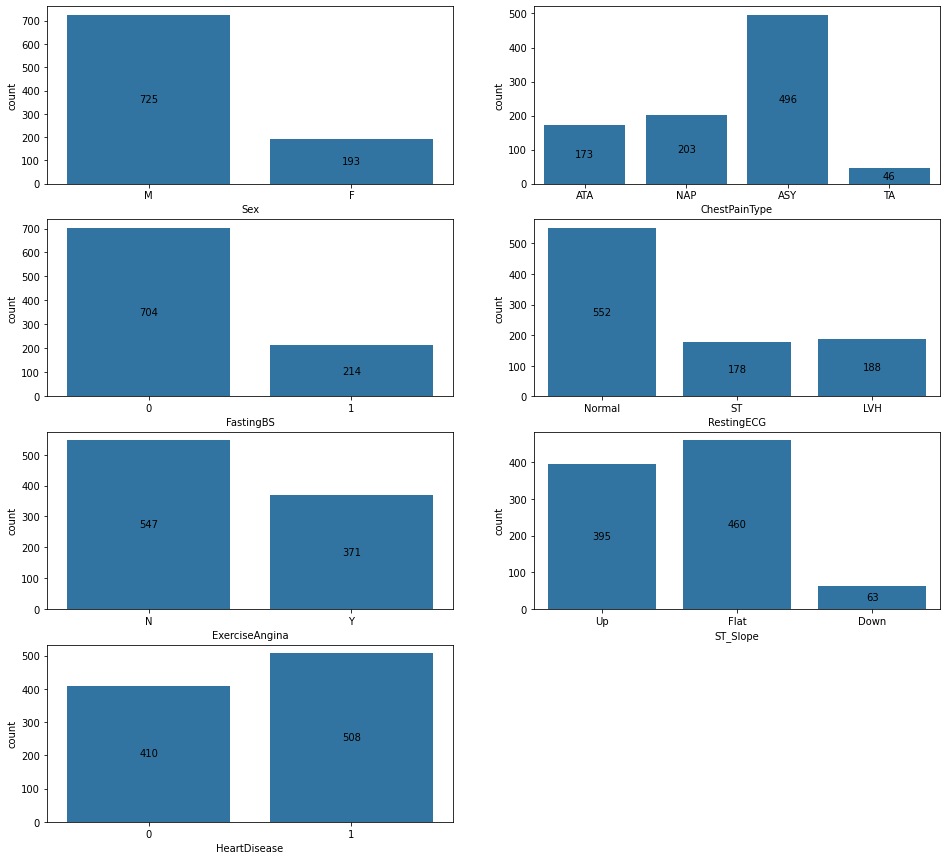

In [8]:
categorical = df[['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina', 'ST_Slope', 'HeartDisease']]
fig = plt.figure(figsize=(16, 15))

for idx, col in enumerate(categorical):
    ax = plt.subplot(4,2, idx+1)
    sns.countplot(x=df[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')
    

This dataset appears to be very highly skewed towards male patients. This may induce bias in our model.


Now let's see how each category of each column is distributed in relation to the HeartDisease column.

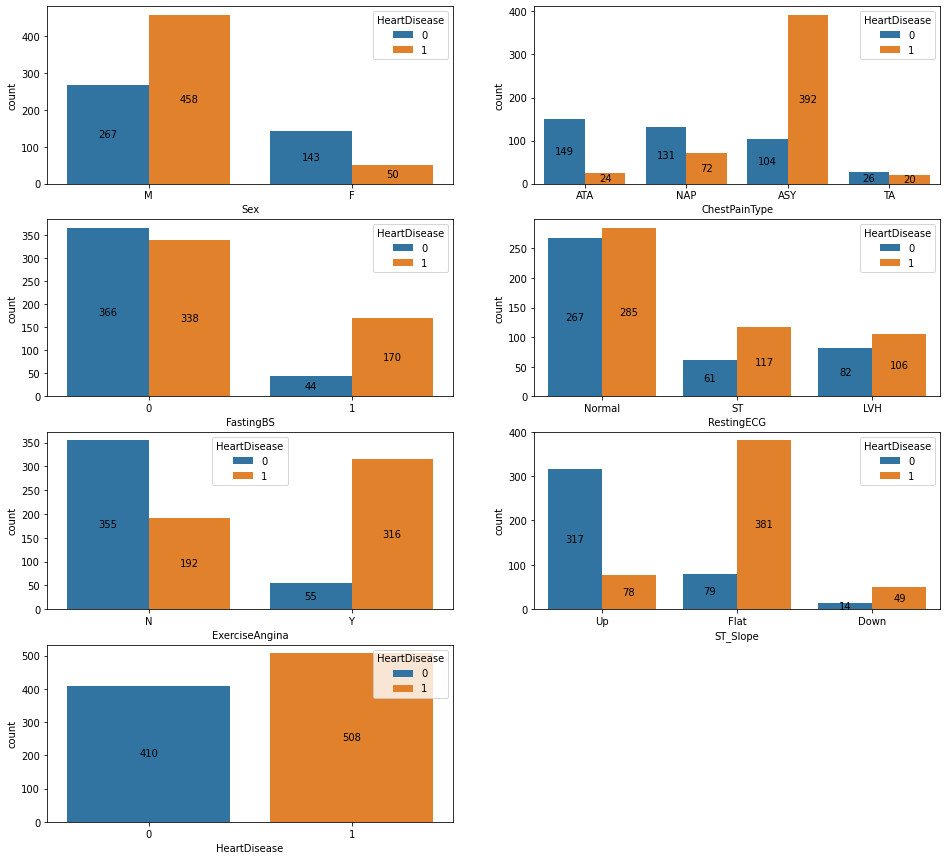

In [9]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    sns.countplot(x=df[col], hue=df['HeartDisease'], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

We can see by these charts the extent of the skew towards male patients, seeing as how males with heart disease far exceed females.
We also notice that certain conditions in patients seem to make them way more likely to have heart-disease.
Such as:  
- asymptomatic chest pain.
- blood sugar greater than 120mg/dl (FastingBS) 
- excercise-induced angina 
- flat ST slope

Let's investigate a little further and see how many patients with heart disease were males over 50 years of age, as well as the median age of patients who were diagnosed with heart disease.

In [10]:
# Males over 50 with heart disease %
male_over_50 = df[(df['Age'] > 50) & (df['Sex'] == 'M')]
num_male_over_50 = len(male_over_50)
percentage = num_male_over_50 / len(df)
f'{percentage*100:.1f}%'

'53.1%'

53.1% of males over 50 were diagnosed with heart disease

In [11]:
# Median age of patients who were diagnosed with heart disease
heart_disease_1 = df[df['HeartDisease'] == 1]
heart_disease_1.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,508.000000,508.000000,508.000000,508.000000,508.000000,508.000000,508.0
mean,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213,1.0
std,8.727056,19.828685,126.391398,0.472332,23.386923,1.151872,0.0
min,31.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,1.0
25%,51.000000,120.000000,0.000000,0.000000,112.000000,0.000000,1.0
50%,57.000000,132.000000,217.000000,0.000000,126.000000,1.200000,1.0
75%,62.000000,145.000000,267.000000,1.000000,144.250000,2.000000,1.0
max,77.000000,200.000000,603.000000,1.000000,195.000000,6.200000,1.0


The median age of all patients who were diagnosed with heart disease is 57.

## Data Cleaning

While there are no missing values in the dataset, there are instances where there are 0 values for stats like Cholesterol, where there shouldn't be a 0 value. We could easily just drop these columns, but it seems we would lose around 170 rows of data -- almost 20% of our data.<br>

What we can do instead is replace the 0 values in the Cholesterol column with the median cholesterol value corresponding to the 'HeartDisease' column.

In [12]:
resting_bp_count = len(df[df['RestingBP'] == 0])
resting_bp_count

1

In [13]:
cholesterol_count = len(df[df['Cholesterol'] == 0])
cholesterol_count

172

In [14]:
hd1 = df[(df['HeartDisease'] == 1) & (df['Cholesterol'] > 0)]
hd0 = df[(df['HeartDisease'] == 0) & (df['Cholesterol'] > 0)]

# Median cholesterol corresponding to heart disease 
cholesterol_med_1 = hd1['Cholesterol'].median()
cholesterol_med_0 = hd0['Cholesterol'].median()

# Cholesterol 0 Heart Disease 1 or 0 Masks
chol_0_hd_0_mask = (df['Cholesterol'] == 0) & (df['HeartDisease'] == 0)
chol_0_hd_1_mask = (df['Cholesterol'] == 0) & (df['HeartDisease'] == 1)

# Replace 0 with Median cholesterol corresponding to HeartDisease 
df.loc[chol_0_hd_0_mask, 'Cholesterol'] = cholesterol_med_0
df.loc[chol_0_hd_1_mask, 'Cholesterol'] = cholesterol_med_1


cholesterol_count = len(df[df['Cholesterol'] == 0])
cholesterol_count


/var/folders/q2/667bjf4j6rg30tsjtz8jgk7r0000gn/T/ipykernel_17644/2471817062.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '231.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[chol_0_hd_0_mask, 'Cholesterol'] = cholesterol_med_0


0

## Feature Selection

Now that the data is cleaned, features can be selected for our model. Below are features we can start with: 

- Age
- Sex 
- ChestPainType
- Cholesterol
- FastingBS

We'll need to explore how each column correlates to one another. But first, dummy variables need to be created for each of the categorical features.

<AxesSubplot:>

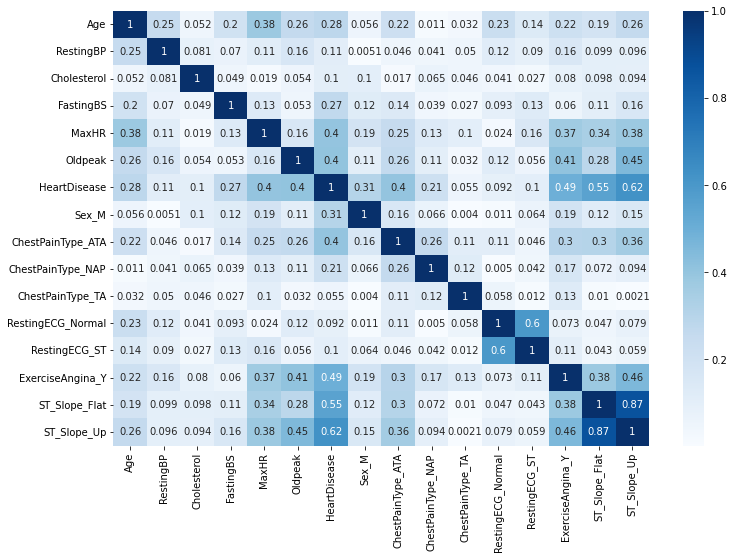

In [15]:
# X_train = pd.get_dummies(X_train, columns=['marital', 'education'], drop_first=True)
df = pd.get_dummies(df, drop_first=True)
corr = abs(df.corr())
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='Blues')



<AxesSubplot:>

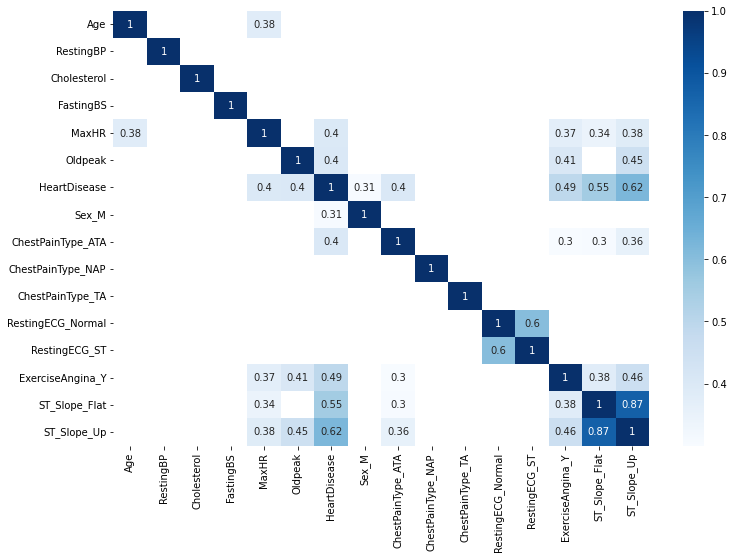

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(corr[corr > 0.3], annot=True, cmap='Blues')

From this heatmap, we can see that 

- ExerciseAngina_Y 
- ST_Slope_Flat 
- ST_Slope_Up 
- Max_HR 
- ChestPainType
- Oldpeak 

have higher than 0.3 correlations to heart disease.

## Building A Classifier I 

We'll now create and train multiple models using one of the higher correlated features at a time.

In [17]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=88)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.25, random_state=33)

high_corr_features = ['ExerciseAngina_Y','Oldpeak','ST_Slope_Flat','ST_Slope_Up', 'ChestPainType_ATA','MaxHR']

for feature in high_corr_features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The knn classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The knn classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 71.30%
The knn classifier trained on Oldpeak and with k = 3 has an accuracy of 68.70%
The knn classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 77.39%
The knn classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 80.43%
The knn classifier trained on ChestPainType_ATA and with k = 3 has an accuracy of 71.74%
The knn classifier trained on MaxHR and with k = 3 has an accuracy of 58.26%


The model that uses ST_Slope_Up performs the best with an accuracy of 80.43%

## Building a Classifier II

Now we'll try training a model on all of the features together. But before we do that, we'll have to normalize all of the data.

### Normalizing data

In [18]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[high_corr_features])
X_val_scaled = scaler.transform(X_val[high_corr_features])
knn2 = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
accuracy2 = knn.score(X_val_scaled, y_val)

print(f'Knn classifier trained on all features and with a k = 3 has an accuracy of {accuracy2*100:.2f}%')


Knn classifier trained on all features and with a k = 3 has an accuracy of 80.00%


The accuracy of the model trained on all features seems to be just slightly less accurate than the best result of the individual feature tests.

## Hyperparameter Tuning

Now that we have a resonably well-performing model, we can experiment with the parameters and hyperparameters. To do this, we'll use GridSearchCV.

In [22]:
X_train2, X_test, y_train2, y_test = train_test_split(X,y,test_size=0.25, random_state=33)
X_train_scaled2 = scaler.fit_transform(X_train2[high_corr_features])
grid_params = {
    'n_neighbors':range(1,20),
    'metric':['minkowski','manhattan']
}
knn_gs = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn_gs, param_grid=grid_params, scoring='accuracy')
knn_grid.fit(X_train_scaled2, y_train2)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': range(1, 20)},
             scoring='accuracy')

In [23]:
knn_grid.best_score_*100, knn_grid.best_params_

(84.01354067491799, {'metric': 'minkowski', 'n_neighbors': 18})

After tuning the hyperparameters, we were able to improve the results to ~84% from 80%

## Model Evaluation on Test Set 

In [24]:
X_test_scaled = scaler.transform(X_test[high_corr_features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, predictions)
print(f'Model Accuracy on Test set using best params: {accuracy_test*100:.2f}')

Model Accuracy on Test set using best params: 81.74


The accuracy of our model is 81.74% This means it has a high likelihood to accurately predict whether a patient is at risk for heart disease. However, ~82% might not be accurate enough to be applied realistically. The model would still be wrong roughly 20% of the time.

Some things that can be tried next to get better results are:

- Trying out different features
- Expanding the grid search parameters to identify better hyperparameters
- Try other algorithms that could perform better than k-NN
- Collect more data